# Imports

In [4]:
import matplotlib.pyplot as plt
import pickle
import copy
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Custom imports
from models import AudioNet
from methods import load_and_split_data, train_one_epoch, evaluate, create_confusion_matrix

### Supports Model Training on external GPUs ###
#from google.colab import drive
#drive.mount('/content/drive')

# Train/Test/Validation Split

In [2]:
# Load the preprocessed data
data_path = 'data_tensor.pt'
labels_path = 'labels_tensor.pt'

train_data, train_labels, validation_data, validation_labels, test_data, test_labels = load_and_split_data(data_path, labels_path)

# Save test data and labels for VIL model accuracy evaluation
torch.save(test_data, 'test_data.pt')
torch.save(test_labels, 'test_labels.pt')

# Model Training & Evaluation

In [3]:
# Setup device (GPU highly recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the GPU if available
model = AudioNet().to(device)

# Setup optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler; implemented like Becker et al. (2018)
scheduler = StepLR(optimizer, step_size=50000, gamma=0.5)

# Training and evaluation loop
num_epochs = 200
batch_size = 100

# Lists to store metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []

# Implement early stopping to prevent overfitting
early_stopping_patience = 10    # Number of epochs to wait for improvement before stopping
early_stopping_counter = 0      # Tracks how many epochs have gone by without improvement
best_val_loss = float('inf')    # Initialize best validation loss as infinity
best_model_state = copy.deepcopy(model.state_dict())  # A deep copy of the best model's weights

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, criterion, scheduler, train_data, train_labels, batch_size, device)
    val_loss, val_accuracy, true_labels, all_predictions = evaluate(model, criterion, validation_data, validation_labels, batch_size, device, transformation='Orig')
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        early_stopping_counter = 0  # Reset counter
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        break
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Load the best model weights
model.load_state_dict(best_model_state)

# After early stopping, evaluate the model on the test set using the best parameters
test_loss, test_accuracy, true_labels, all_predictions = evaluate(model, criterion, test_data, test_labels, batch_size, device, transformation='Orig')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
transformation = 'Conv'
create_confusion_matrix(true_labels, all_predictions, classes, transformation)

KeyboardInterrupt: 

# Plot Metrics

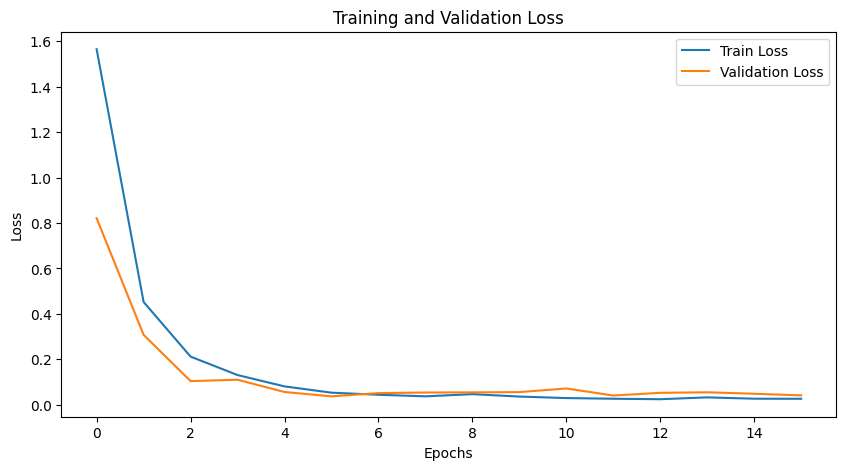

In [7]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

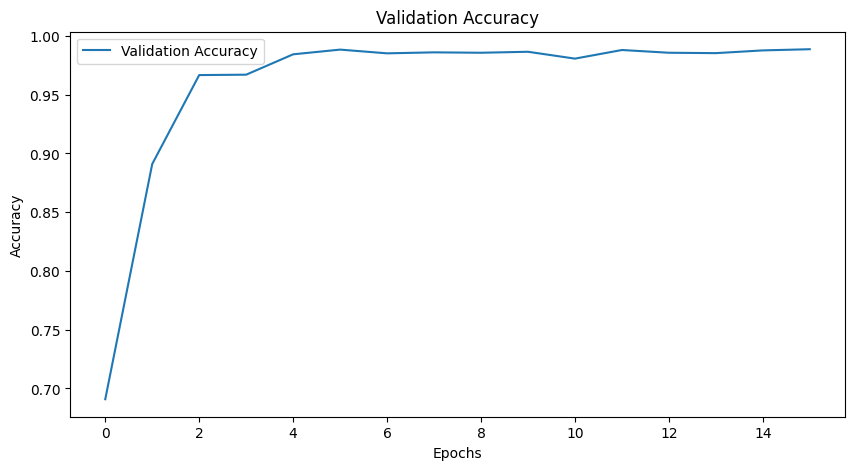

In [8]:
# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save Model Parameters

In [ ]:
# Save model parameters
torch.save(model.state_dict(), 'model_weights.pth')
print("Model parameters saved successfully!")

In [ ]:
# Optional: Save metrics
def save_metrics(metrics, filename):
    with open(filename, 'wb') as f:
        pickle.dump(metrics, f)
        print("Metrics saved successfully!")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}
save_metrics(metrics, 'model_metrics.pkl')

### Optional: Load Metrics

In [6]:
def load_metrics(filename):
    with open(filename, 'rb') as f:
        metrics = pickle.load(f)
    return metrics

loaded_metrics = load_metrics('model_metrics.pkl')
train_losses = loaded_metrics['train_losses']
val_losses = loaded_metrics['val_losses']
val_accuracies = loaded_metrics['val_accuracies']